# Прогнозирование вероятности оттока пользователей для фитнес-центров

<div style="text-align: right">Работа Юлии Халеевой </div>

## Описание проекта

Задача проекта: изучить данные пользователей фитнес-центра и подготовить план действий по удержанию клиентов.
Мы планируем:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

проанализировать основные признаки, наиболее сильно влияющие на отток;

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

**Описание данных**

Набор данных включает следующие поля:

`Churn` — факт оттока в текущем месяце;

Текущие поля в датасете:
Данные клиента за предыдущий до проверки факта оттока месяц:

`gender` — пол;

`Near_Location` — проживание или работа в районе, где находится фитнес-центр;

`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

`Phone` — наличие контактного телефона;

`Age` — возраст;

`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);

`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);

`Group_visits` — факт посещения групповых занятий;

`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;

`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;

`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import math as mth
import warnings
import os
from plotly import graph_objects as go
import re
from io import BytesIO
import requests
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("max_colwidth", 120)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
#Загрузим данные
#для работы в тренажере

if os.path.exists('/datasets/gym_churn.csv'):
    df = pd.read_csv('/datasets/gym_churn.csv')

#для работы локально
else:
    df = pd.read_csv('gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


## Исследовательский анализ данных (EDA) 

In [4]:
df = df.rename(columns={'gender': 'Gender'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
#проверим, есть ли пропуски
df.isna().sum()

Gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [7]:
#проверим, есть ли дубликаты
df.duplicated().sum()

0

In [8]:
len(df)

4000

Наши данные содержат 4000 наблюдений, 13 признаков (объясняющих переменных) и целевую переменную `Churn` -- факт ухода в текущем месяце. Видим, что ни пропусков в данных, ни дубликатов нет.

Среди признаков есть 6 категориальных:
`gender` — пол;

`Near_Location` — проживание или работа в районе, где находится фитнес-центр;

`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

`Phone` — наличие контактного телефона;

`Group_visits` — факт посещения групповых занятий.


In [9]:
# Сохраним копию файла
df_initial = df

In [10]:
df.describe()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Посмотрим на социальный портрет пользователя.
    
Это с равной вероятностью мужчина или женщина,
    
30 лет,
    
живет близко от фитнес-клуба,
    
оформляет абонемент на 5 месяцев,
    
в трети случаев приходит по промокоду,
    
в четверти случаев покидает клуб.

In [11]:
def hist_plot(data, column):
    '''Функция строит гистограмму для конкретной переменной
    '''
    plt.figure(figsize=(13,7))
    sns.set_style("whitegrid") 
    sns.displot(data, x=column, hue="Churn", alpha=0.5, height = 6, aspect = 10/6)
    #plt.legend(['да', 'нет'], title = 'Отток', loc = 'best')
    plt.title(f'Распределение признака {column}', fontsize=15)
    plt.xlabel('Признак', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

In [12]:
feature_list = df.drop(['Churn'], axis = 1).columns
feature_list

Index(['Gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month'],
      dtype='object')

<Figure size 936x504 with 0 Axes>

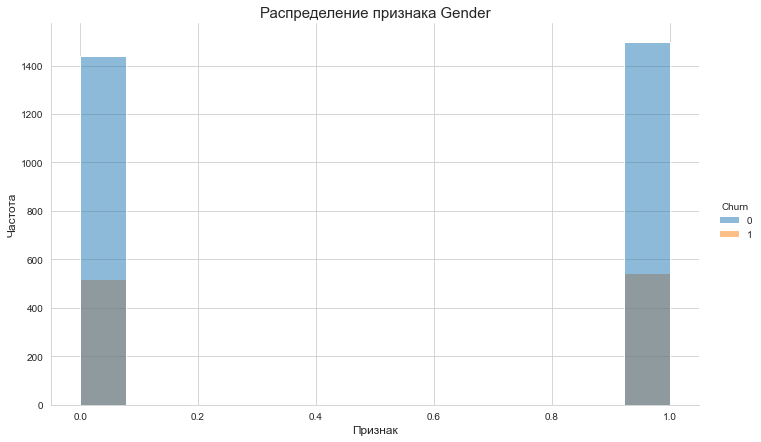

<Figure size 936x504 with 0 Axes>

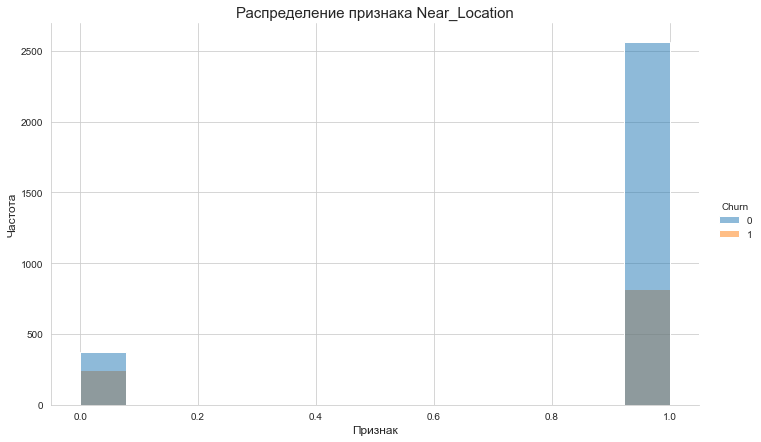

<Figure size 936x504 with 0 Axes>

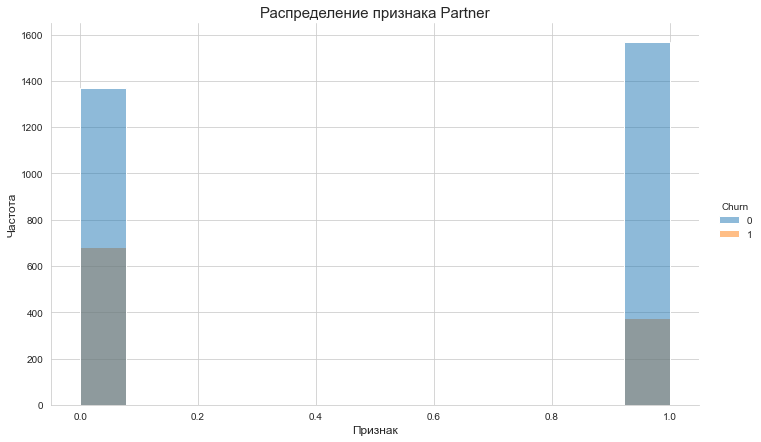

<Figure size 936x504 with 0 Axes>

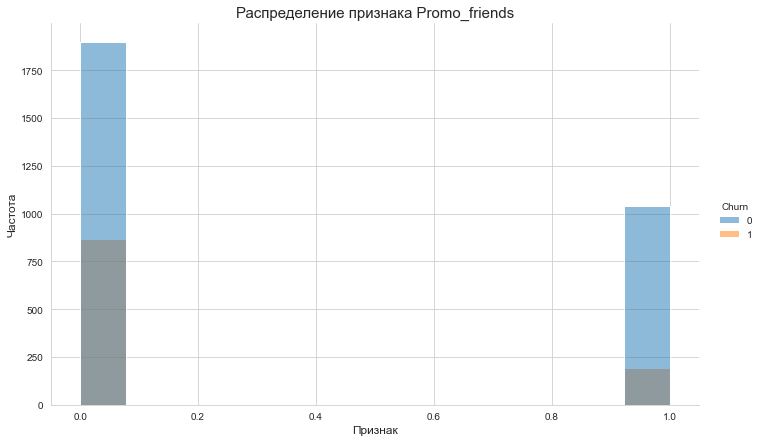

<Figure size 936x504 with 0 Axes>

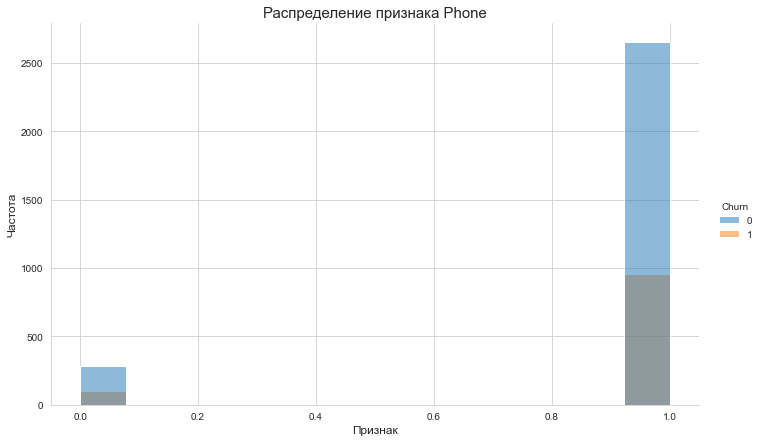

<Figure size 936x504 with 0 Axes>

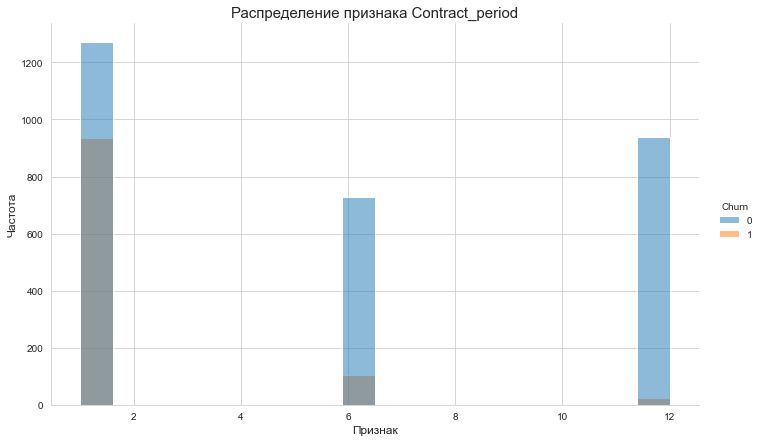

<Figure size 936x504 with 0 Axes>

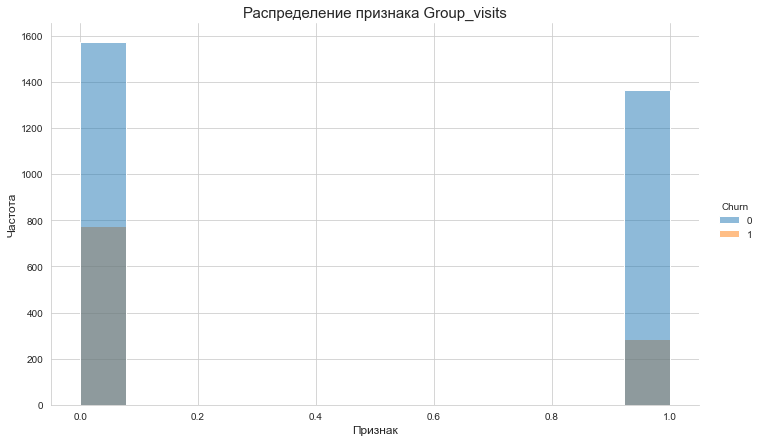

<Figure size 936x504 with 0 Axes>

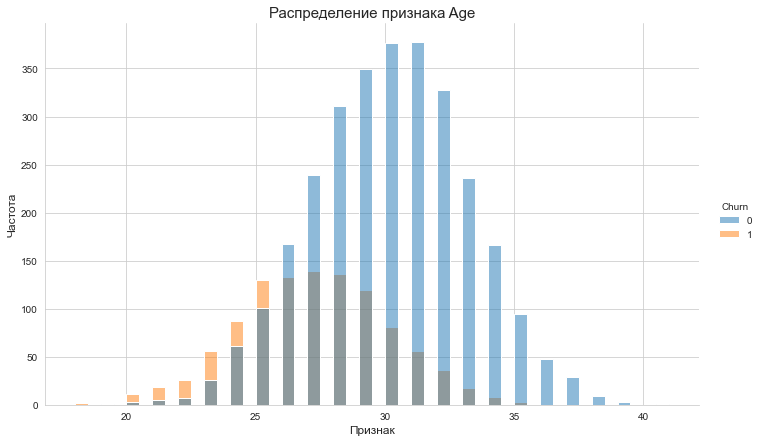

<Figure size 936x504 with 0 Axes>

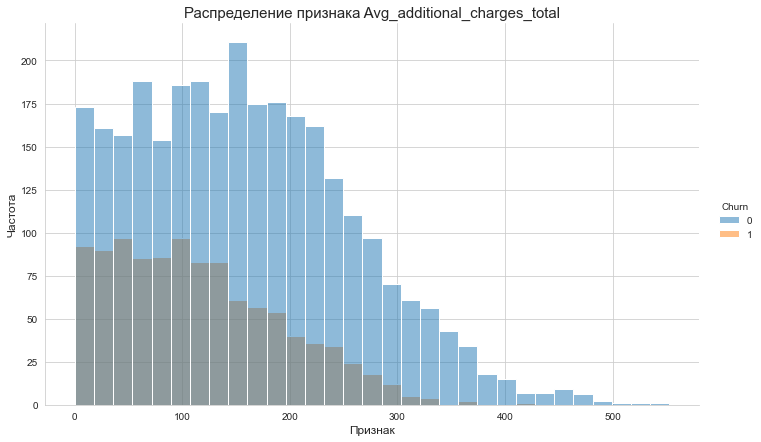

<Figure size 936x504 with 0 Axes>

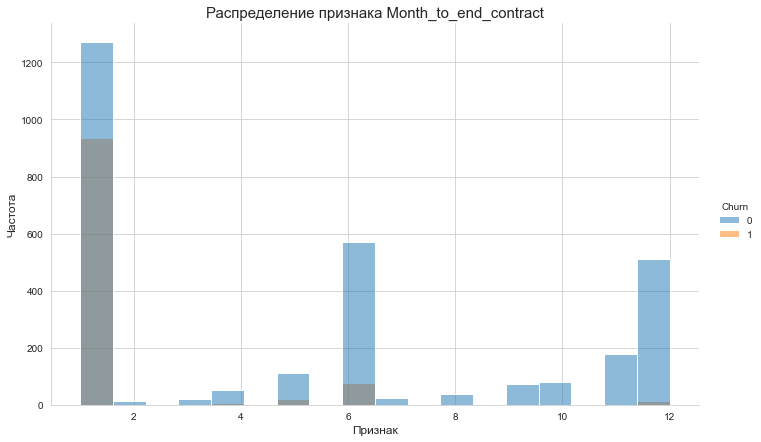

<Figure size 936x504 with 0 Axes>

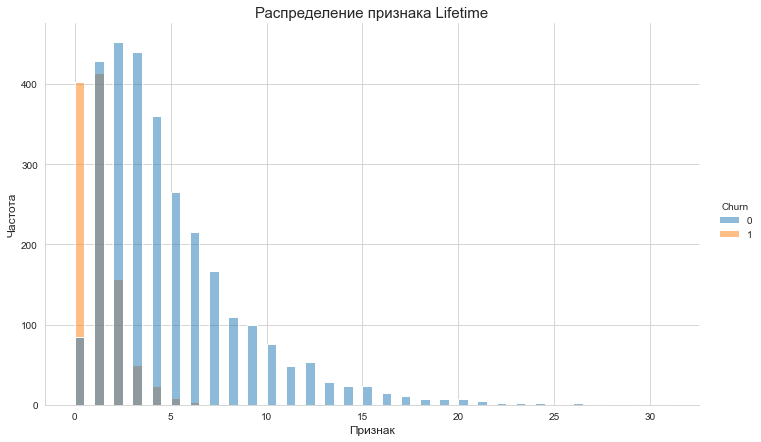

<Figure size 936x504 with 0 Axes>

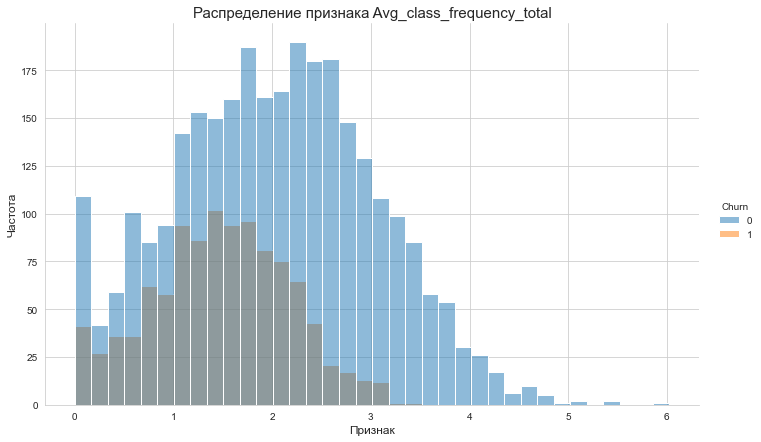

<Figure size 936x504 with 0 Axes>

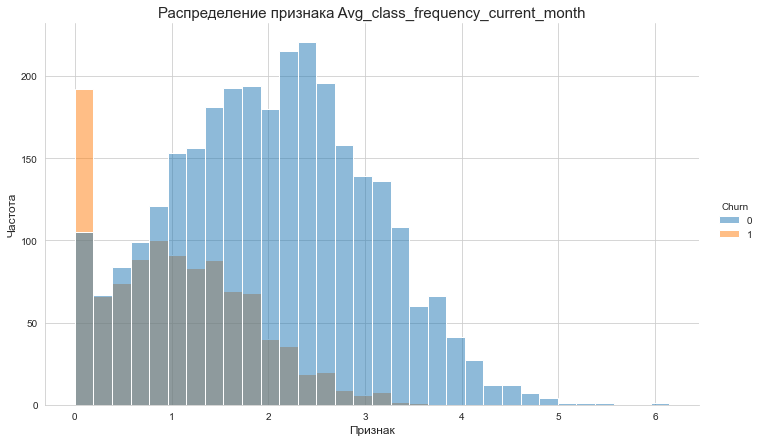

In [13]:
for feature  in feature_list: 
    hist_plot(df, feature)

Особенных выбросов мы не наблюдаем. Наши категориальные переменные уже имеют вид дамми-переменных, так что не требуют дополнительного преобразования.

Видим, что 
    
по полу различий практически нет

живущих близко в выборке гораздо больше и доля "утекающих" среди них меньше
    
среди тех, кто работает в компании-партнере, отток ниже
    
тех, кто пришел по промокоду, меньше, но и отток среди них меньше

абонемент бывает на 1 месяц, на 6 месяцев и на год, среди тех, кто покупает абонемент на месяц, отток самый большой, среди тех, кто на год, самый маленький
    
более молодые уходят чаще
    
те, кто ходит реже и меньше тратит на дополнительные услуги, уходит чаще.

In [14]:
#построим матрицу корреляций
df_corr = df.corr()

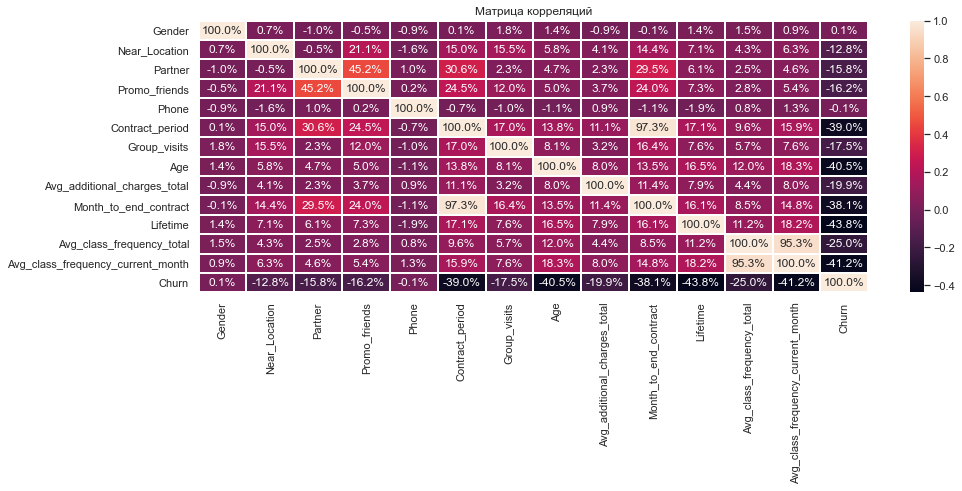

In [15]:
plt.figure(figsize=(15, 5))
sns.set(style='white')
plt.title('Матрица корреляций')
sns.heatmap(df_corr, annot=True, fmt='.1%', linewidths=1, linecolor='white')
plt.show()
plt.close()

Видим, что имеются мультиколлинеарность, обнаруживаются две пары сильно коррелированных признаков:

`Avg_class_frequency_total` 

`Avg_class_frequency_current_month`    

и

`Month_to_end_contract`

`Contract_period`

Исключим по одному признаку из каждой пары, оставим
`Avg_class_frequency_total` 
и
`Contract_period`

In [16]:
df = df.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month'], axis = 1) 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        4000 non-null   int64  
 1   Near_Location                 4000 non-null   int64  
 2   Partner                       4000 non-null   int64  
 3   Promo_friends                 4000 non-null   int64  
 4   Phone                         4000 non-null   int64  
 5   Contract_period               4000 non-null   int64  
 6   Group_visits                  4000 non-null   int64  
 7   Age                           4000 non-null   int64  
 8   Avg_additional_charges_total  4000 non-null   float64
 9   Lifetime                      4000 non-null   int64  
 10  Avg_class_frequency_total     4000 non-null   float64
 11  Churn                         4000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


## Построение модели прогнозирования оттока клиентов
Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

Разбейте данные на обучающую и валидационную выборку функцией train_test_split().

Обучите модель на train-выборке двумя способами:

логистической регрессией,

случайным лесом.

Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 

Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.


In [18]:
#Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
X = df.drop('Churn', axis = 1) 
y = df['Churn'] 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [20]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [21]:
# обучим StandardScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
 
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель с помощью логистической регрессии.

In [22]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [23]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83


Теперь обучим модель с помощью случайного леса.

In [24]:
# зададим алгоритм для нашей модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 

In [25]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions =  rf_model.predict(X_test) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test)[:,1] # Ваш код здесь


In [26]:
# выведем все метрики
print_all_metrics(
    y_test, 
    rf_predictions,
    rf_probabilities,
    title = 'Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79


Видим, что логистическая регрессия на стандартизованных данных дает лучшие результаты, чем случайный лес (лучшие в смысле метрик accuracy, precision и recall)

## Кластеризация
Сделайте кластеризацию клиентов

Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):

Стандартизируйте данные.

Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. 
Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.

Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).

Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?


In [27]:
# обучим StandardScaler на всей выборке
scaler = StandardScaler()
scaler.fit(X)
 
# Преобразуем все данные
X_st = scaler.transform(X)

In [28]:
#построим таблицу связок между объектами
linked = linkage(X_st, method = 'ward') 

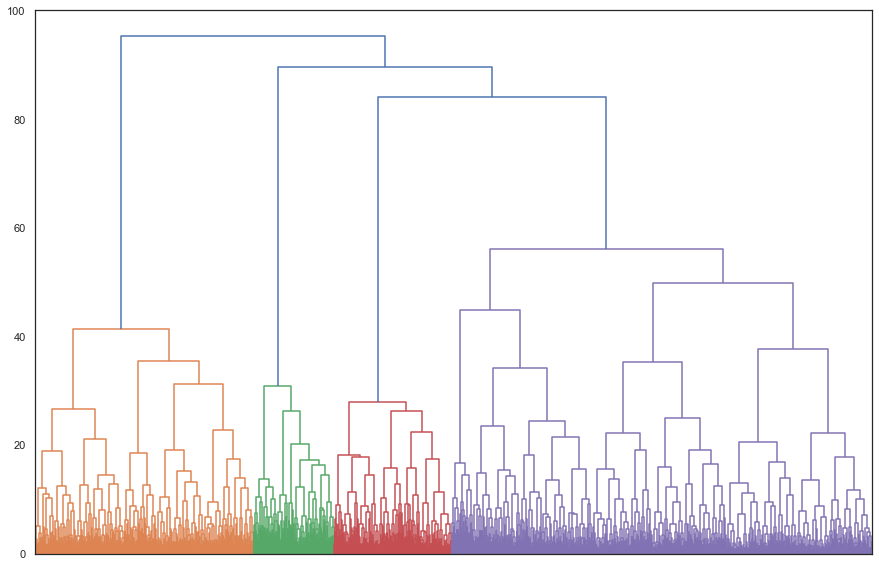

In [29]:
#построим дендрограмму (no_labels = True, чтобы дендрограмма строилась быстрее)
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels = True)
plt.show() 

Дендрограмма демонстрирует, что данные разумно разделить на 4 кластера.

Следуя заданию, разделим их на 5 кластеров.

In [30]:
# определим функцию для построения графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
 

In [31]:
# зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_st)
 
# сохраним метки кластера в поле нашего датасета
df['cluster'] = labels
 
# выведем статистику по средним значениям наших признаков по кластеру
df.groupby('cluster').mean()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster,,,,,,,,,,,,
0,0.50,0.00,0.49,0.08,1.00,3.00,0.23,28.71,137.39,3.01,1.77,0.40
1,0.49,1.00,0.94,0.88,1.00,7.66,0.52,29.47,149.41,4.06,1.91,0.12
2,0.56,1.00,0.27,0.05,1.00,5.24,0.53,30.96,186.70,5.78,2.40,0.02
3,0.49,1.00,0.22,0.08,1.00,2.08,0.29,27.58,116.46,1.93,1.47,0.55
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.85,0.27


Видим, что кластеры отличаются по доле оттока. 

Самый надежный кластер 2, оттуда практически никто не уходит (отток = 0,02). Это люди, которые живут рядом, пришли давно и не по промокоду, чаще других ходят на групповые занятия и вообще в клуб, больше денег тратят на сопутствующие услуги в клубе.

Следующий по надежности кластер 1 (отток = 0,12). Это люди, работающие в компании-партнере, они тоже чаще других ходят на групповые занятия и вообще в клуб и больше денег тратят на сопутствующие услуги в клубе (но меньше, чем кластер 2).

Самый ненадежный кластер 3 (отток = 0,55). Это люди, пришедшие недавно, у них самый короткий срок, на который оформлен абонемент. Они реже прочих ходят на групповые занятия и меньше денег тратят на сопутствующие услуги в клубе. Они чуть моложе остальных и чаще относятся к полу , обозначенному 1.

Кластер 0 тоже достаточно ненадежен (отток = 0,4). Этот кластер отличается от других тем, что люди тут не живут рядом с клубом.

Кластер 4 -- люди, которые не оставили свой телефон, на удивление не отличаются чрезмерной ненадежностью, их резултат равен среднему (0,27).



Построим графики распределения переменных по кластерам.

In [32]:
#если бы мы хотели разделить выборку на кластеры, можно было бы сделать это так
# for i in range(4):
#     df_i = df.query('cluster==@i')

In [33]:
def countplot_by_clusters(data, column):
    #Функция строит распределение для конкретной дискретной переменной по кластерам
    
    plt.figure(figsize=(13,7))
    sns.set_style("whitegrid") 
    sns.countplot(data=data, x=column, hue = 'cluster')
    plt.title(f'Распределение {column}', fontsize=15)
    plt.xlabel('Признак', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend(title = 'Кластер')
    plt.show()
    plt.close()

In [34]:
def boxplot(data, column):
    #Функция строит распределение для конкретной непрерывной переменной
    
    plt.figure(figsize=(13,7))
    sns.set_style("whitegrid") 
    sns.boxplot(data = data, x = column)
    plt.title(f'Распределение {column} в кластере {i}', fontsize=15)
    plt.xlabel('Признак', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend('')
    plt.show()
    plt.close()

In [35]:
df.columns

Index(['Gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total',
       'Churn', 'cluster'],
      dtype='object')

In [36]:
discreet_feature_list = df.columns.drop(['Avg_additional_charges_total', 
                    'Lifetime', 'Avg_class_frequency_total', 'Age' ])

In [37]:
continous_feature_list = ['Avg_additional_charges_total', 
                    'Lifetime', 'Avg_class_frequency_total', 'Age' ]

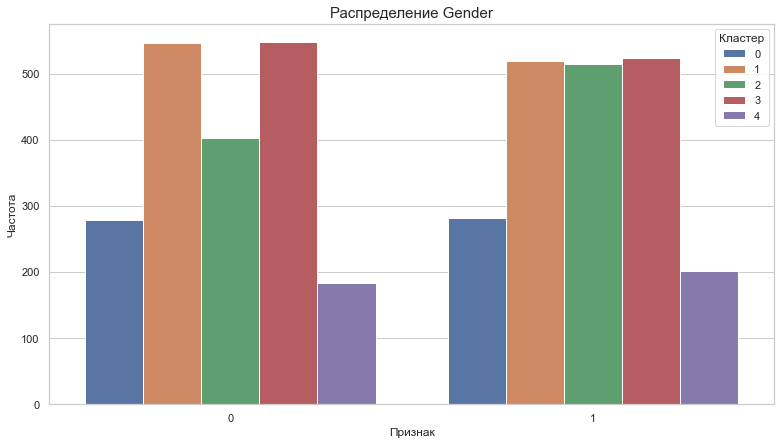

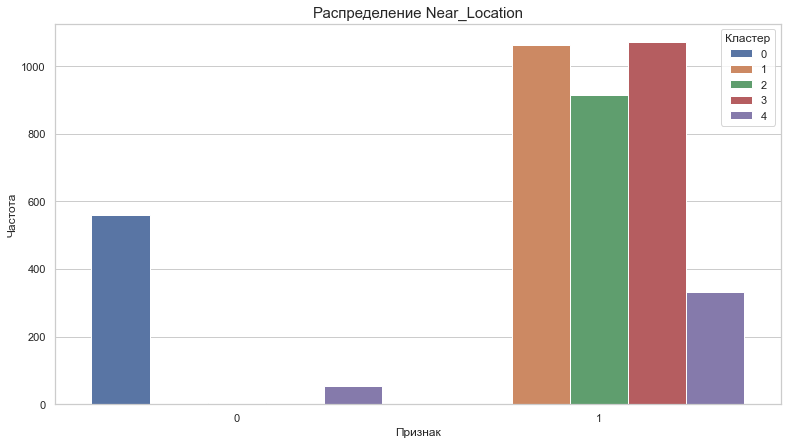

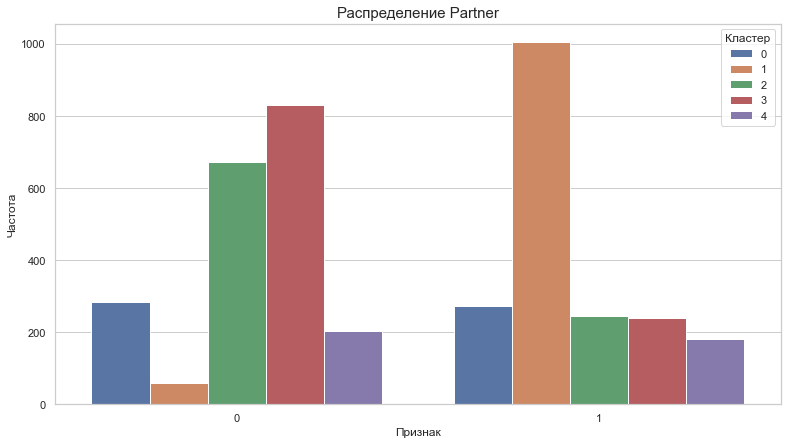

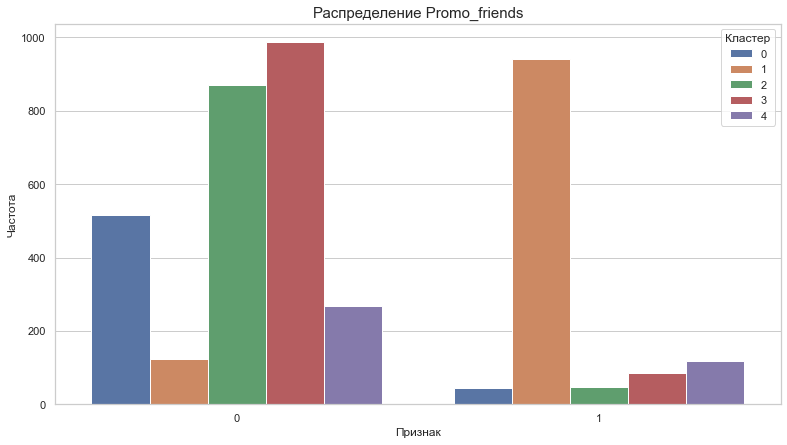

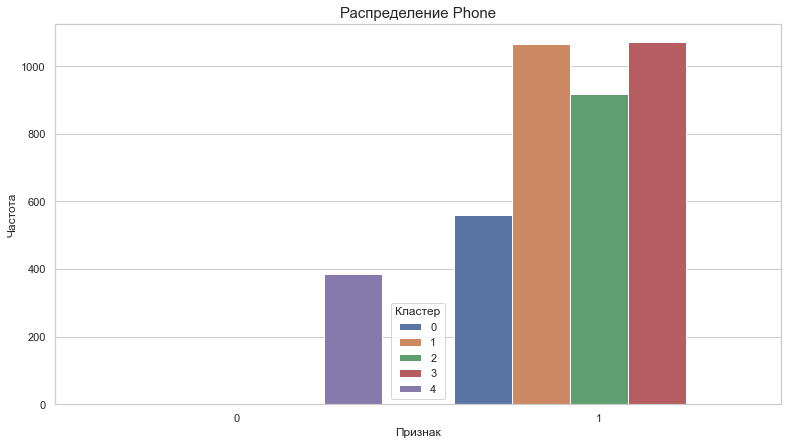

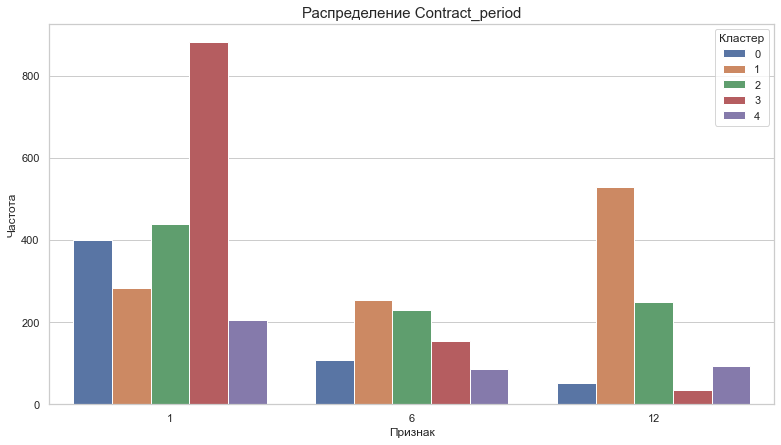

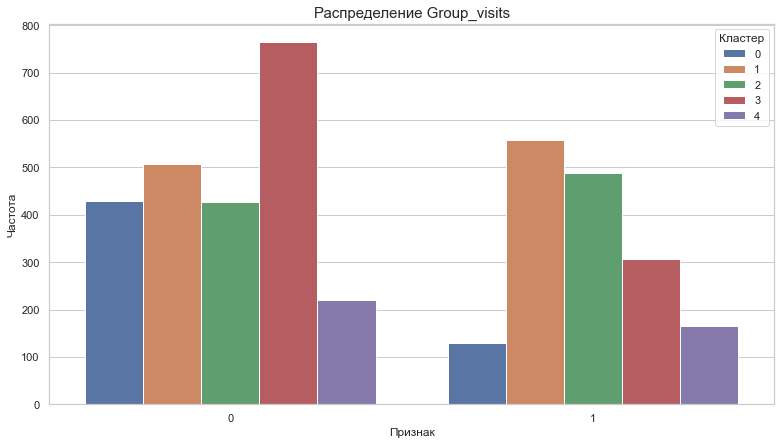

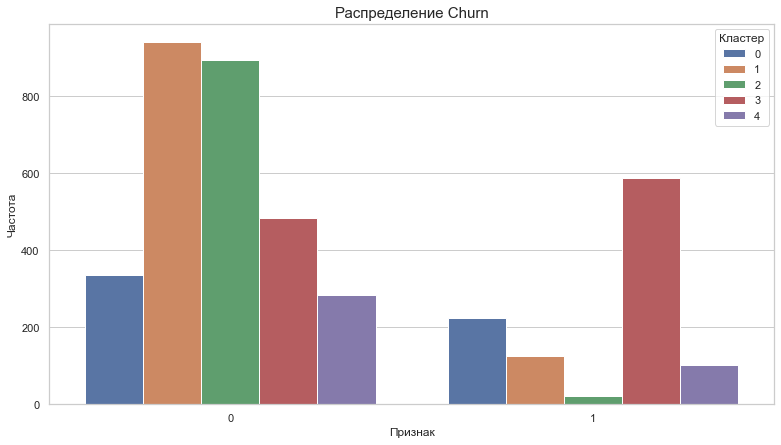

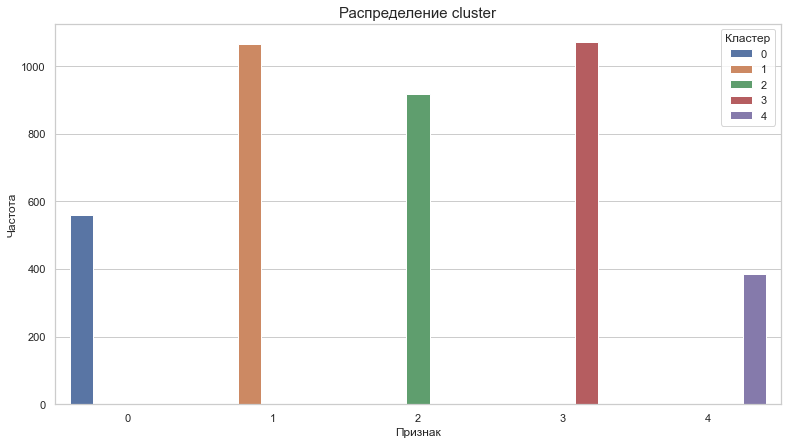

In [38]:
for feature  in discreet_feature_list: 
    countplot_by_clusters(df, feature)

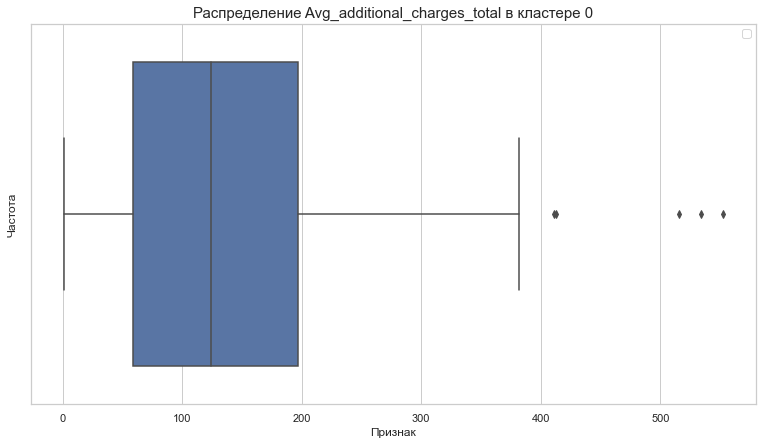

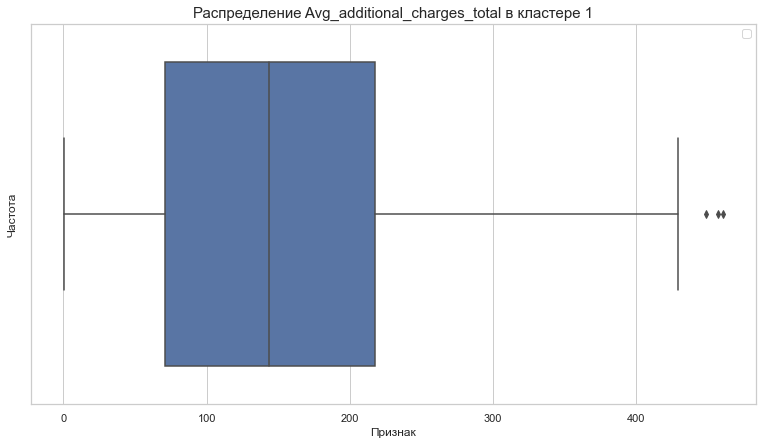

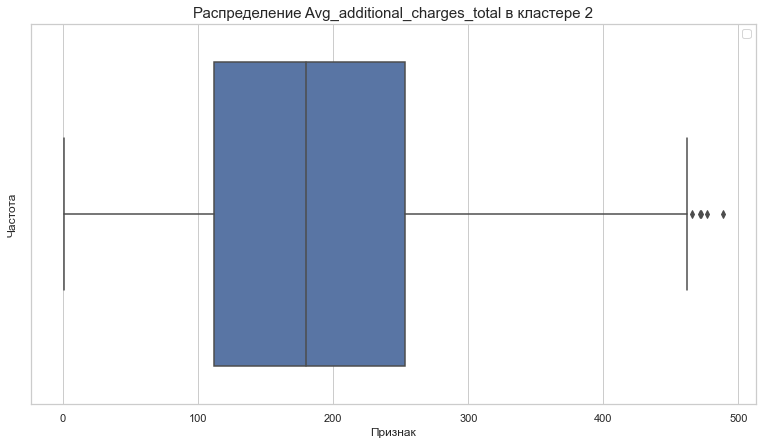

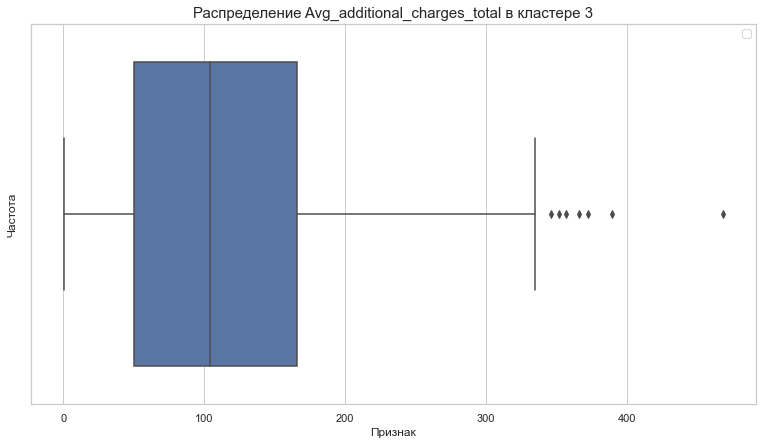

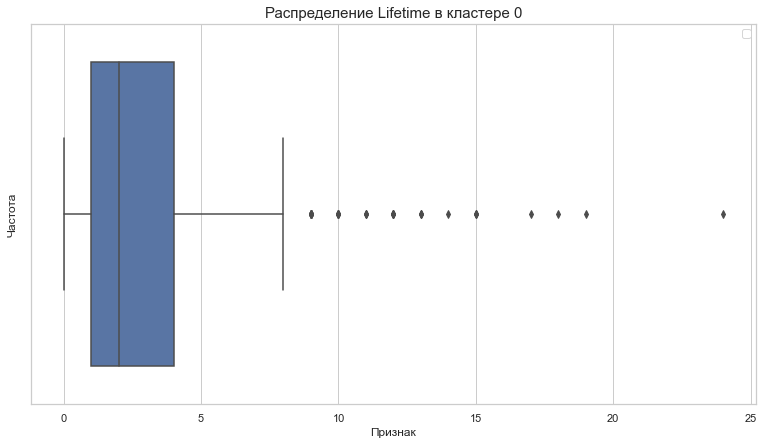

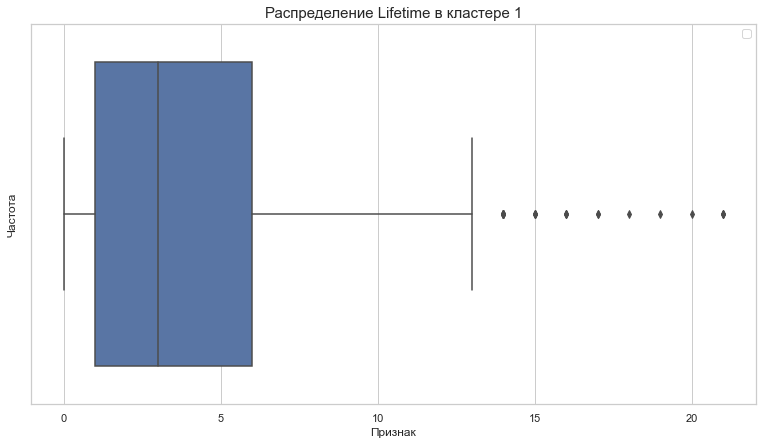

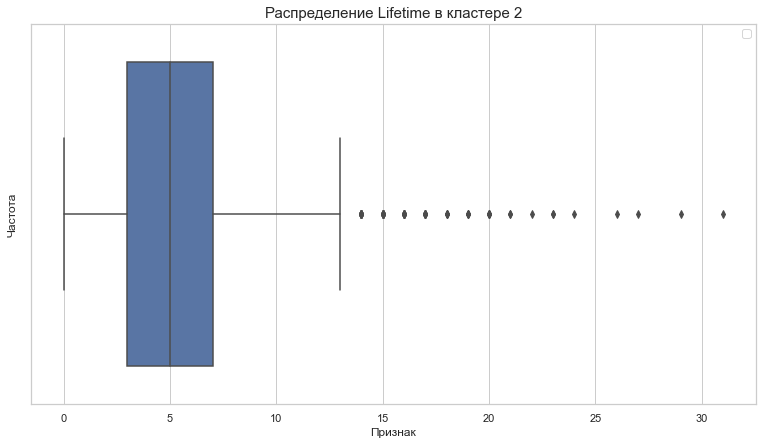

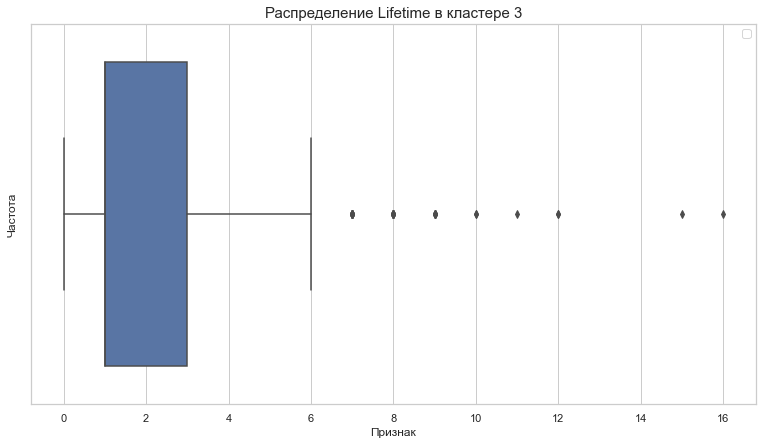

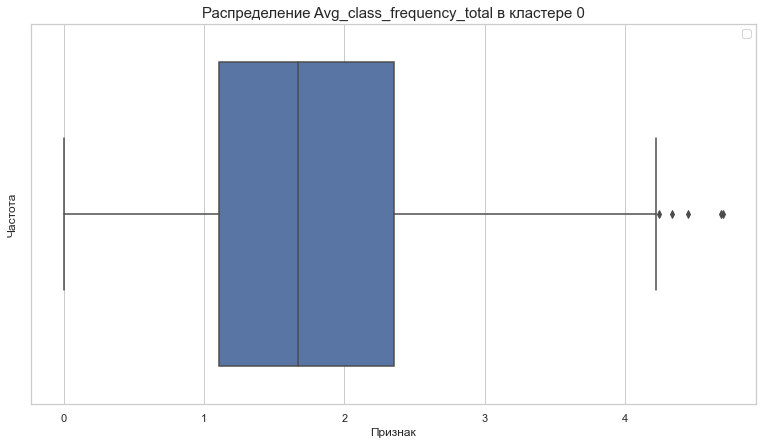

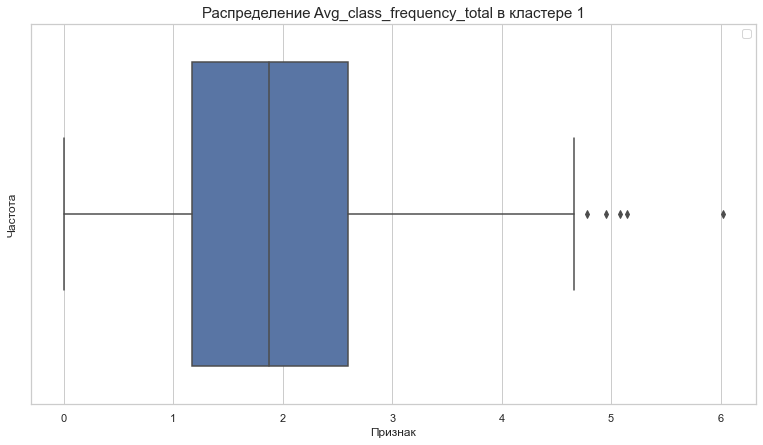

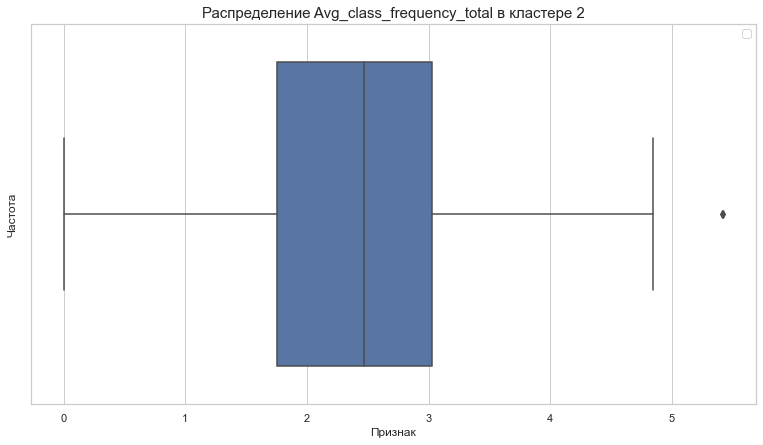

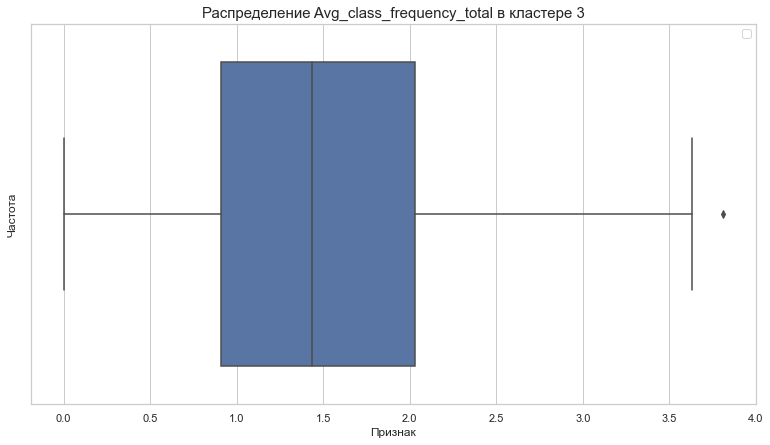

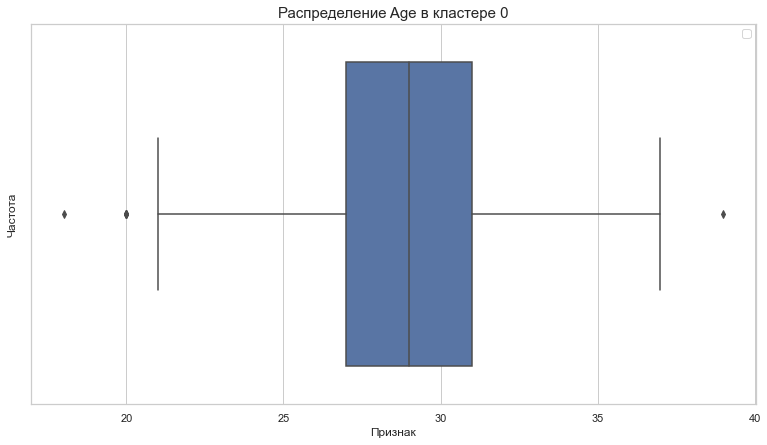

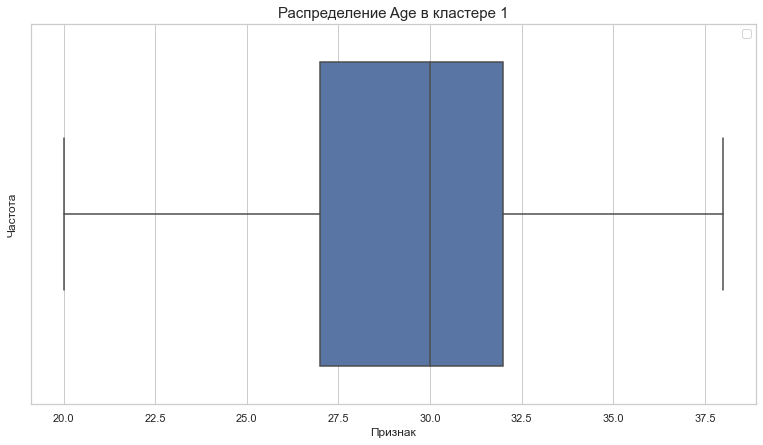

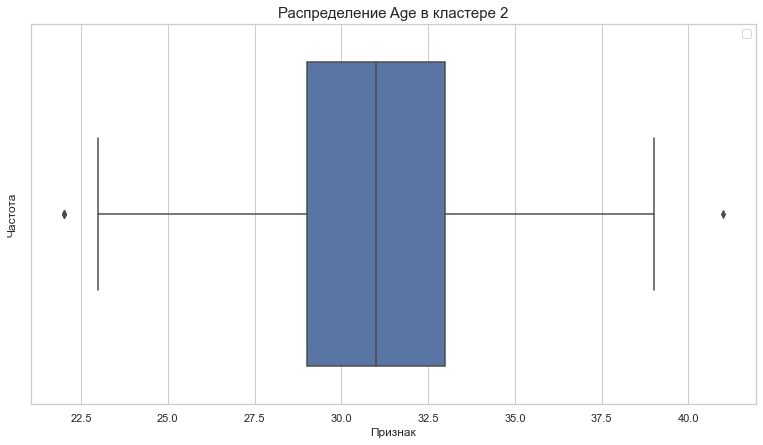

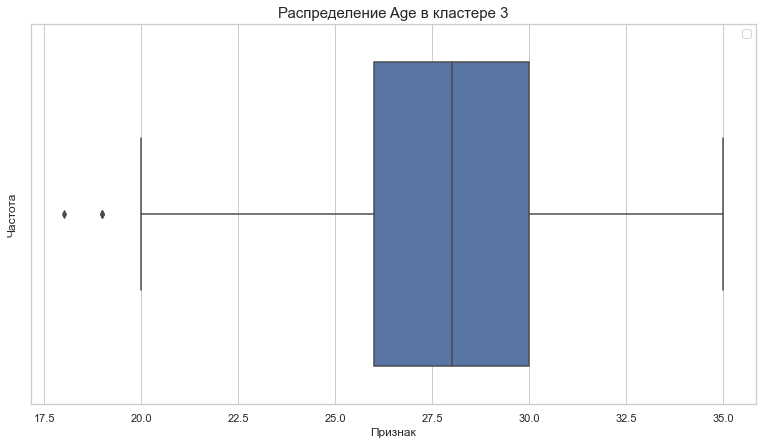

In [39]:
for feature  in continous_feature_list: 
    for i in range(4):
        boxplot(df.loc[df['cluster']==i], feature)

Мы построили распределения признаков отдельно по кластерам.

Запишем некоторые наблюдения:
    
далеко от клуба живут только персонажи из кластера 0 и некоторые из кластера 4, все остальные живут близко

во всех кластерах есть те, кто работает на предприятии-партнере, но в кластере 1 их существенно больше

по промокоду приходят представители всех кластеров, но в кластере 1 их опять существенно больше

телефон не оставляют только персонажи из кластера 4

абонемент на 1 месяц покупают персонажи из всех кластеров, но в 3 кластере таких существенно больше.

На последних графиках из первой серии мы можем сравнить размер кластеров, видим, что 1 и 3 самые большие, а 4 самый маленький.


## Выводы и базовые рекомендации по работе с клиентами 

Мы видим, что некоторые характеристики коррелированы с тем, что клиент менее вероятно стремится покинуть наш клуб. 
Мы не можем уверенно говорить о причинно-следственной связи, но тем не менее кажется осмысленным обратить внимание на клиентов из этих групп.

Сюда относятся 

те, кто пришли по промокоду

те, кто работает в компании-партнере

те, кто часто ходит на групповые занятия и просто в клуб

те, кто больше денег тратит на сопутствующие услуги в клубе.

Также более надежными являются более старые клиенты и те, кто покупает более длинные абонементы (здесь особенно вероятна обратная причинно-следственная связь: тот, кому нравится и подходит клуб, не планирует его покидать и покупает длинный абонемент).

Рекомендуемые маркетинговые действия: 

1. Следить за клиентами из этих групп, удостоверяясь, что они довольны. При недовольстве стараться удержать клиентов, предлагая какие-то поощрительные меры (например, бесплатные тренировки из тех).

2. Те, кто живут далеко, не являются особенно надежными клиентами, так что, видимо, нам не имеет особенного смысла вешать рекламу далеко от клуба, а стоит сосредоточиться на нашем районе.

3. Политика раздачи промокодов себя оправдывает, так что ее стоит продолжать, но именно в том виде и по тем каналам, по которым они распространябтся сейчас, нельзя быть уверенным, что новый канал приведет к нам таких же надежных клиентов.


